In [1]:
import numpy as np
import gym
import os

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

import uniform_attack

In [2]:
# Load model
current_dir = os.getcwd()
save_dir = os.path.abspath(os.path.join(current_dir, os.pardir)) + "/ppo/models/"
model = PPO.load(save_dir + "/cartpole-v1/cartpole_v1_ppo_15000")

In [3]:
# Set environment
env = gym.make('CartPole-v1')

In [ ]:
# Test different perturbation weights for theta
theta_data = {
    'theta_perturbation': [],
    'mean_reward': [],
    'mean_perturbation': []
}

for j in range(300):
    num_episodes = 100
    all_episodes_rewards = []
    all_episodes_perturbation = []

    for i in range(num_episodes):
        episode_rewards = []
        episode_perturbations = []
        done = False
        obs = env.reset()

        timestep = 0

        perturbation = (0.0, 0.0, 2*j/100, 0.0)
        
        while not done:

            timestep += 1

            ### uniform attack ###
            adversarial_sample, total_perturbation = uniform_attack.perturb(env, obs, perturbation)
            ### uniform attack ###        
            
            action, _states = model.predict(adversarial_sample)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            episode_perturbations.append(total_perturbation)

        all_episodes_rewards.append(sum(episode_rewards))
        all_episodes_perturbation.append(sum(episode_perturbations) / timestep)
    
    # Save data for theta perturbation weights
    theta_data['theta_perturbation'].append(j/100)
    theta_data['mean_reward'].append(np.mean(all_episodes_rewards))
    theta_data['mean_perturbation'].append(np.mean(all_episodes_perturbation))

    print(f"Finished test for {perturbation} with mean_reward: {np.mean(all_episodes_rewards):.2f} and mean perturbation: {np.mean(all_episodes_perturbation):.2f}")

In [ ]:
# Test different perturbation weights for theta_dot
theta_dot_data = {
    'theta_dot_perturbation': [],
    'mean_reward': [],
    'mean_perturbation': [],
    'mean_attacks': []
}

for j in range(300):
    num_episodes = 100
    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_attacks = []

    for i in range(num_episodes):
        episode_rewards = []
        episode_perturbations = []
        episode_attacks = []
        done = False
        obs = env.reset()

        timestep = 0

        perturbation = (0.0, 0.0, 0.0, 2*j/100)
        
        while not done:

            timestep += 1

            ### uniform attack ###
            adversarial_sample, total_perturbation, attacked = uniform_attack.perturb(env, obs, perturbation)
            ### uniform attack ###        
            
            action, _states = model.predict(adversarial_sample)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            episode_perturbations.append(total_perturbation)
            episode_attacks.append(attacked)

        all_episodes_rewards.append(sum(episode_rewards))
        all_episodes_perturbation.append(sum(episode_perturbations))
        all_episodes_attacks.append(sum(episode_attacks))
    
    # Save data for theta_dot perturbation weights
    theta_dot_data['theta_dot_perturbation'].append(j/100)
    theta_dot_data['mean_reward'].append(np.mean(all_episodes_rewards))
    theta_dot_data['mean_perturbation'].append(np.mean(all_episodes_perturbation))

    print(f"Finished test for {perturbation} with mean reward: {np.mean(all_episodes_rewards):.2f} and mean perturbation: {np.mean(all_episodes_perturbation):.2f}")

In [ ]:
# Test different perturbation weights for x
x_data = {
    'x_perturbation': [],
    'mean_reward': [],
    'mean_perturbation': []
}

for j in range(300):
    num_episodes = 100
    all_episodes_rewards = []
    all_episodes_perturbation = []

    for i in range(num_episodes):
        episode_rewards = []
        episode_perturbations = []
        done = False
        obs = env.reset()

        timestep = 0

        perturbation = (2*j/100, 0.0, 0.0, 0.0)
        
        while not done:

            timestep += 1

            ### uniform attack ###
            adversarial_sample, total_perturbation = uniform_attack.perturb(env, obs, perturbation)
            ### uniform attack ###        
            
            action, _states = model.predict(adversarial_sample)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            episode_perturbations.append(total_perturbation)

        all_episodes_rewards.append(sum(episode_rewards))
        all_episodes_perturbation.append(sum(episode_perturbations) / timestep)
    
    # Save data for x perturbation weights
    x_data['x_perturbation'].append(j/100)
    x_data['mean_reward'].append(np.mean(all_episodes_rewards))
    x_data['mean_perturbation'].append(np.mean(all_episodes_perturbation))

    print(f"Finished test for {perturbation} with mean_reward: {np.mean(all_episodes_rewards):.2f} and mean perturbation: {np.mean(all_episodes_perturbation):.2f}")

In [ ]:
# Test different perturbation weights for x_dot
x_dot_data = {
    'x_dot_perturbation': [],
    'mean_reward': [],
    'mean_perturbation': []
}

for j in range(300):
    num_episodes = 100
    all_episodes_rewards = []
    all_episodes_perturbation = []

    for i in range(num_episodes):
        episode_rewards = []
        episode_perturbations = []
        done = False
        obs = env.reset()

        timestep = 0

        perturbation = (0.0, 2*j/100, 0.0, 0.0)
        
        while not done:

            timestep += 1

            ### uniform attack ###
            adversarial_sample, total_perturbation = uniform_attack.perturb(env, obs, perturbation)
            ### uniform attack ###        
            
            action, _states = model.predict(adversarial_sample)
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)
            episode_perturbations.append(total_perturbation)

        all_episodes_rewards.append(sum(episode_rewards))
        all_episodes_perturbation.append(sum(episode_perturbations) / timestep)
    
    # Save data for x_dot perturbation weights
    x_dot_data['x_dot_perturbation'].append(j/100)
    x_dot_data['mean_reward'].append(np.mean(all_episodes_rewards))
    x_dot_data['mean_perturbation'].append(np.mean(all_episodes_perturbation))

    print(f"Finished test for {perturbation} with mean_reward: {np.mean(all_episodes_rewards):.2f} and mean perturbation: {np.mean(all_episodes_perturbation):.2f}")

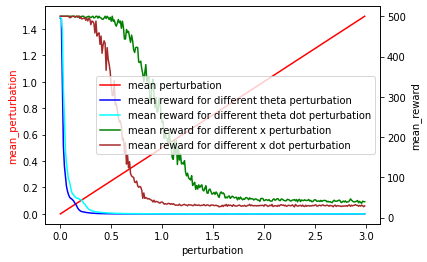

In [24]:
# Plot result

from matplotlib import pyplot as plt


fig, ax1 = plt.subplots()

ax1.set_xlabel('perturbation')
ax1.set_ylabel('mean_perturbation', color='red')
plot1, = ax1.plot(theta_data['theta_perturbation'], theta_data['mean_perturbation'], color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('mean_reward', color='black')
plot2, = ax2.plot(theta_data['theta_perturbation'], theta_data['mean_reward'], color='blue')
plot3, = ax2.plot(theta_dot_data['theta_dot_perturbation'], theta_dot_data['mean_reward'], color='cyan')
plot4, = ax2.plot(x_data['x_perturbation'], x_data['mean_reward'], color='green')
plot5, = ax2.plot(x_dot_data['x_dot_perturbation'], x_dot_data['mean_reward'], color='brown')

plt.legend(
    [plot1, plot2, plot3, plot4, plot5], 
    ['mean perturbation', 'mean reward for different theta perturbation', 'mean reward for different theta dot perturbation',
    'mean reward for different x perturbation', 'mean reward for different x dot perturbation']
    )
plt.show()

In [5]:
# Evaluate model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(model, Monitor(env), n_eval_episodes=100)
print(f"mean_reward : {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward : 500.00 +/- 0.00


In [32]:
# Test uniform attack with optimized parameters

num_episodes = 100
all_episodes_rewards = []
all_episodes_perturbation = []

for i in range(num_episodes):
    episode_rewards = []
    episode_perturbations = []
    done = False
    obs = env.reset()

    timestep = 0
    
    while not done:

        timestep += 1

        ### uniform attack ###
        adversarial_sample, perturbation = uniform_attack.perturb(env, obs, (0.0, 0.0, 0.5, 0.5))
        ### uniform attack ###        
        
        action, _states = model.predict(adversarial_sample)
        obs, reward, done, info = env.step(action)
        episode_rewards.append(reward)
        episode_perturbations.append(perturbation)

    all_episodes_rewards.append(sum(episode_rewards))
    all_episodes_perturbation.append(sum(episode_perturbations) / timestep)

print(f"Finished!")
print(f"Final mean reward: {np.mean(all_episodes_rewards):.2f}")
print(f"Mean perturbation: {np.mean(all_episodes_perturbation):.2f}")
print(f"Num episodes: {num_episodes}")

Finished!
Final mean reward: 10.10
Mean perturbation: 0.25
Num episodes: 100
